# Plot BlueSeis BSPF Events from Catalog

! Should be run in pygmt environment !

With pressure sensor parascientific and new sensor 

In [9]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

In [10]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [11]:
config = {}

config['minlatitude'] = 31-1
config['maxlatitude'] = 35+1
config['minlongitude'] = -119-1
config['maxlongitude'] = -114+1

config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime("2022-10-01")
config['tend'] = obs.UTCDateTime("2023-03-31")

config['eventfile'] = "BSPF_event_catalog_extended"

config['path_trigger'] = data_path+"/BSPF/trigger2/"
config['path_catalog'] = data_path+"/BSPF/data/"

config['outpath'] = data_path+"/BSPF/"

In [12]:
# def __export_new_events(config, events_old, events):
    
#     ## combine new and old catalog
#     tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
#     ## remove duplicates
#     df = tmp.drop_duplicates(subset=['index'], keep=False)
#     ## sort and set index
#     df = df.sort_index(ascending=False)
#     df.set_index('index', inplace=True, drop=True)
    
#     ## export new events to pickle file
#     print(f" -> export new events: {config['outpath']}new_events.pkl")
#     df.to_pickle(config['outpath']+"new_events.pkl")
    
#     del tmp, df  

In [13]:
def __cat_to_df(cat):
    
    from pandas import DataFrame
    
    times = []
    lats = []
    lons = []
    deps = []
    magnitudes = []
    magnitudestype = []
    
    for event in cat:
        if len(event.origins) != 0 and len(event.magnitudes) != 0:
            times.append(event.origins[0].time.datetime)
            lats.append(event.origins[0].latitude)
            lons.append(event.origins[0].longitude)
            deps.append(event.origins[0].depth)
            magnitudes.append(event.magnitudes[0].mag)
            magnitudestype.append(event.magnitudes[0].magnitude_type )
            
    df = DataFrame({'latitude':lats,'longitude':lons,'depth':deps,
                    'magnitude':magnitudes,'type':magnitudestype}, 
                     index = times
                  )
    
    return df

In [14]:
def __add_distances_and_backazimuth(config, df):

    from obspy.geodetics.base import gps2dist_azimuth

    dist = np.zeros(len(df))
    baz = np.zeros(len(df))

    
    for ii, ev in enumerate(df.index):
        try:
            dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],
                                                     df.latitude[ii], df.longitude[ii],
                                                     a=6378137.0, f=0.0033528106647474805
                                                     )
        except:
            print(" -> failed to compute!")
            
    df['backazimuth'] = baz
    df['distances_km'] = dist/1000

    return df

In [15]:
def __read_pickle(path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [16]:
def __find_matches(trigger_events, catalog):

    trigger_times, cosum = [], []
    for trig in trigger_events:
        trigger_times.append(trig['time'])
        cosum.append(trig['coincidence_sum'])

    
    matches, time_diffs, events_triggered, idxs = [], [], [], []

    ## extract origin times from catalog
    event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]
    
    
    for trigger_time in trigger_times:

        ## compute time differences in seconds
        diff = [event_time-trigger_time for event_time in event_times]
        
        ## only the ones before the trigger in time
        abs_diff = [abs(d) for d in diff if d < 0]
        
        ## get closest event
        t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))
                
        time_diffs.append(t_min)
        matches.append(trigger_time)
        events_triggered.append(event_times[t_idx])
        idxs.append(t_idx)
        
    cat_sel = [catalog.events[idx] for idx in idxs]
        
        
    t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
    plt.figure(figsize=(15,5))
    for tt, dd, cosum in zip(t_days, time_diffs, cosum):
        if cosum == 4:
            plt.scatter(tt, dd, zorder=2, color='red', s=10)
        if cosum == 5:
            plt.scatter(tt, dd, zorder=2, color='orange', s=10)
        if cosum == 6:
            plt.scatter(tt, dd, zorder=2, color='green', s=10)
            
    plt.yscale("log")
    plt.grid(which="both", zorder=-1, ls=":")
    plt.ylabel("Time Differences (s)")
    plt.xlabel("Time (days)")
    plt.xlim(0, 190)
    
    return np.array(matches), np.array(events_triggered), cat_sel

## Load Data

### load catalog with all events

In [17]:
cat_all = obs.read_events(config['path_catalog']+config['eventfile']+"_all.xml")

events_all_df = __cat_to_df(cat_all)

events_all_df = __add_distances_and_backazimuth(config, events_all_df)

In [18]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]

### load triggered events

In [19]:
trigger_events = __read_pickle(config['path_trigger'], "trigger_all.pkl")

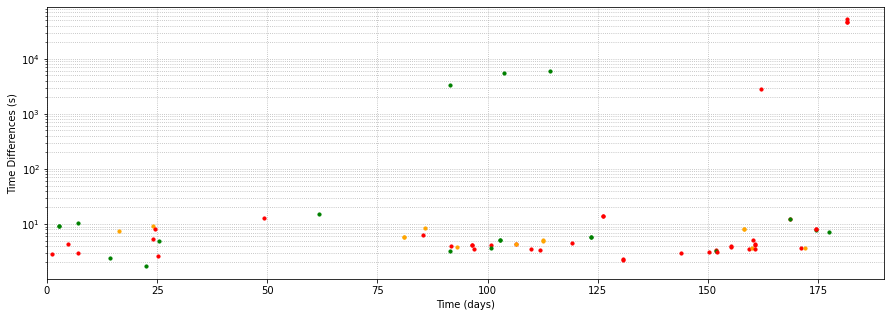

In [20]:
matches, events_triggered, cat_select = __find_matches(trigger_events, cat_all)

In [21]:
cat_select_df = __cat_to_df(cat_select)

cat_select_df = __add_distances_and_backazimuth(config, cat_select_df)

cat_select_df = cat_select_df.rename_axis('timestamp').reset_index()
cat_select_df['seconds'] = [abs((cat_select_df.timestamp.min()-tt).total_seconds()) for tt in cat_select_df.timestamp]

In [24]:
cat_select_df.magnitude.min()

0.38

In [26]:
cat_select_df[cat_select_df.magnitude == 0.38]

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
31,2023-01-12 17:36:38.160,33.540833,-116.717833,2840.0,0.38,ml,72.295143,25.561987,8863881.72


## Plot Triggered Catalog

In [74]:
def __plot_timeline(catalog_df, catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    catalog_all_df.sort_values("magnitude")
    catalog_df.sort_values("magnitude")
    
    
    cax = ax.scatter(catalog_df.timestamp, 
                     catalog_df.distances_km, 
                     s=4**catalog_df.magnitude, 
                     c=catalog_df.magnitude, 
                     alpha=1.0, 
                     cmap='viridis'
                    )

    ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=4**catalog_all_df.magnitude, c='grey', alpha=0.5, zorder=-1)

    
    cbar = plt.colorbar(cax, ax=ax, cmap='viridis', pad=0.01, aspect=15, drawedges=False)
    cbar.set_label(label='Magnitude', size=14, color="white", labelpad=-38)
    
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)
    
#     ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())
#     ax.set_xlim(obs.UTCDateTime("2022-09-29"), obs.UTCDateTime("2023-04-03"))

    ax.set_title(f"triggered={len(catalog_df)} of {len(catalog_all_df)}")
    
    plt.show();
    return fig

In [75]:
def __makeplot_eventmap(config, data1, data2):
    

    import pygmt
    import pandas as pd

    
    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    resolution = "30s"

    fig = pygmt.Figure()
    
#     fig.basemap(region=region, projection="M15c", frame=True)


    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)
    
    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
    
    ## adjust land and sea/lakes
#     land = topo_data * pygmt.grdlandmask(region=region, 
#                                          spacing=resolution, 
#                                          maskvalues=[0, 1], 
#                                          resolution="f"
#                                         )
    wet = topo_data * pygmt.grdlandmask(region=region, 
                                        spacing=resolution, 
                                        maskvalues=[1, "NaN"], 
                                        resolution="f"
                                       )
    
    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M5i',
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )     


#     cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    fig.grdimage(
        grid=wet,
        region=region,
        projection='M5i',
        shading=True,
        cmap='seafloor',
        frame=True,
        nan_transparent=True
    )
    
    
    cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)    
    fig.colorbar(cmap=cmap, position="g-118.8/31.45+w3c/0.3c+h", box="+gwhite+c0.1+r", 
                 frame=["x+lElevation", r"y+l(km)"], scale=0.001)    


    ## add coastlines
    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)
#     fig.coast(rivers="1/0.5p,blue") # Rivers

    
    ## colorbar colormap
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])

#     cmap_depth = pygmt.makecpt(cmap="rainbow", series=[data1.depth.min()/1000, data1.depth.max()/1000])
    
#     ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )    

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04
        *2**data1.magnitude,
#         fill=data1.depth/1000,
        fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.1p,black",
        transparency=50,        
    )    

    ## plot PFO
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )
    
    fig.text(
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )
    

    ## add depth colorbar
#     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
    fig.colorbar(frame='af+l"Days"', cmap=cmap_mag, position="JMR+o-2c/3c+w5c/0.5c+n+mc", scale=1/86400)
    
    ## save figure to file
    fig.savefig(config['outpath']+'tmp_event_map.png')

    fig.show();
    return fig

### Plots

In [76]:
events_all_df[events_all_df.magnitude == 6.2]

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
4335,2022-11-22 16:39:05.789,30.7936,-116.3907,10000.0,6.2,mww,358.897734,312.442773,4552231.359


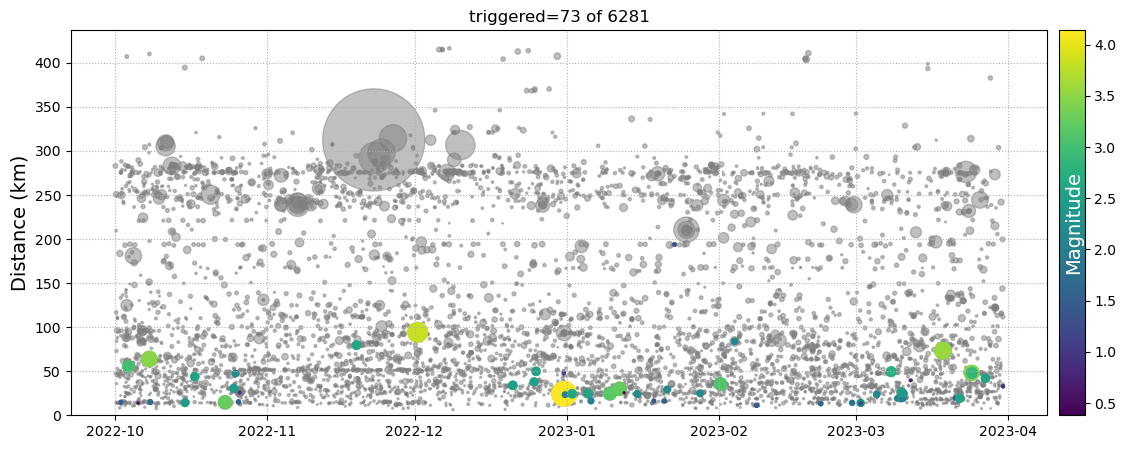

In [77]:
fig = __plot_timeline(cat_select_df, events_all_df)

fig.savefig("timeline_triggered.png")

### Map Plot

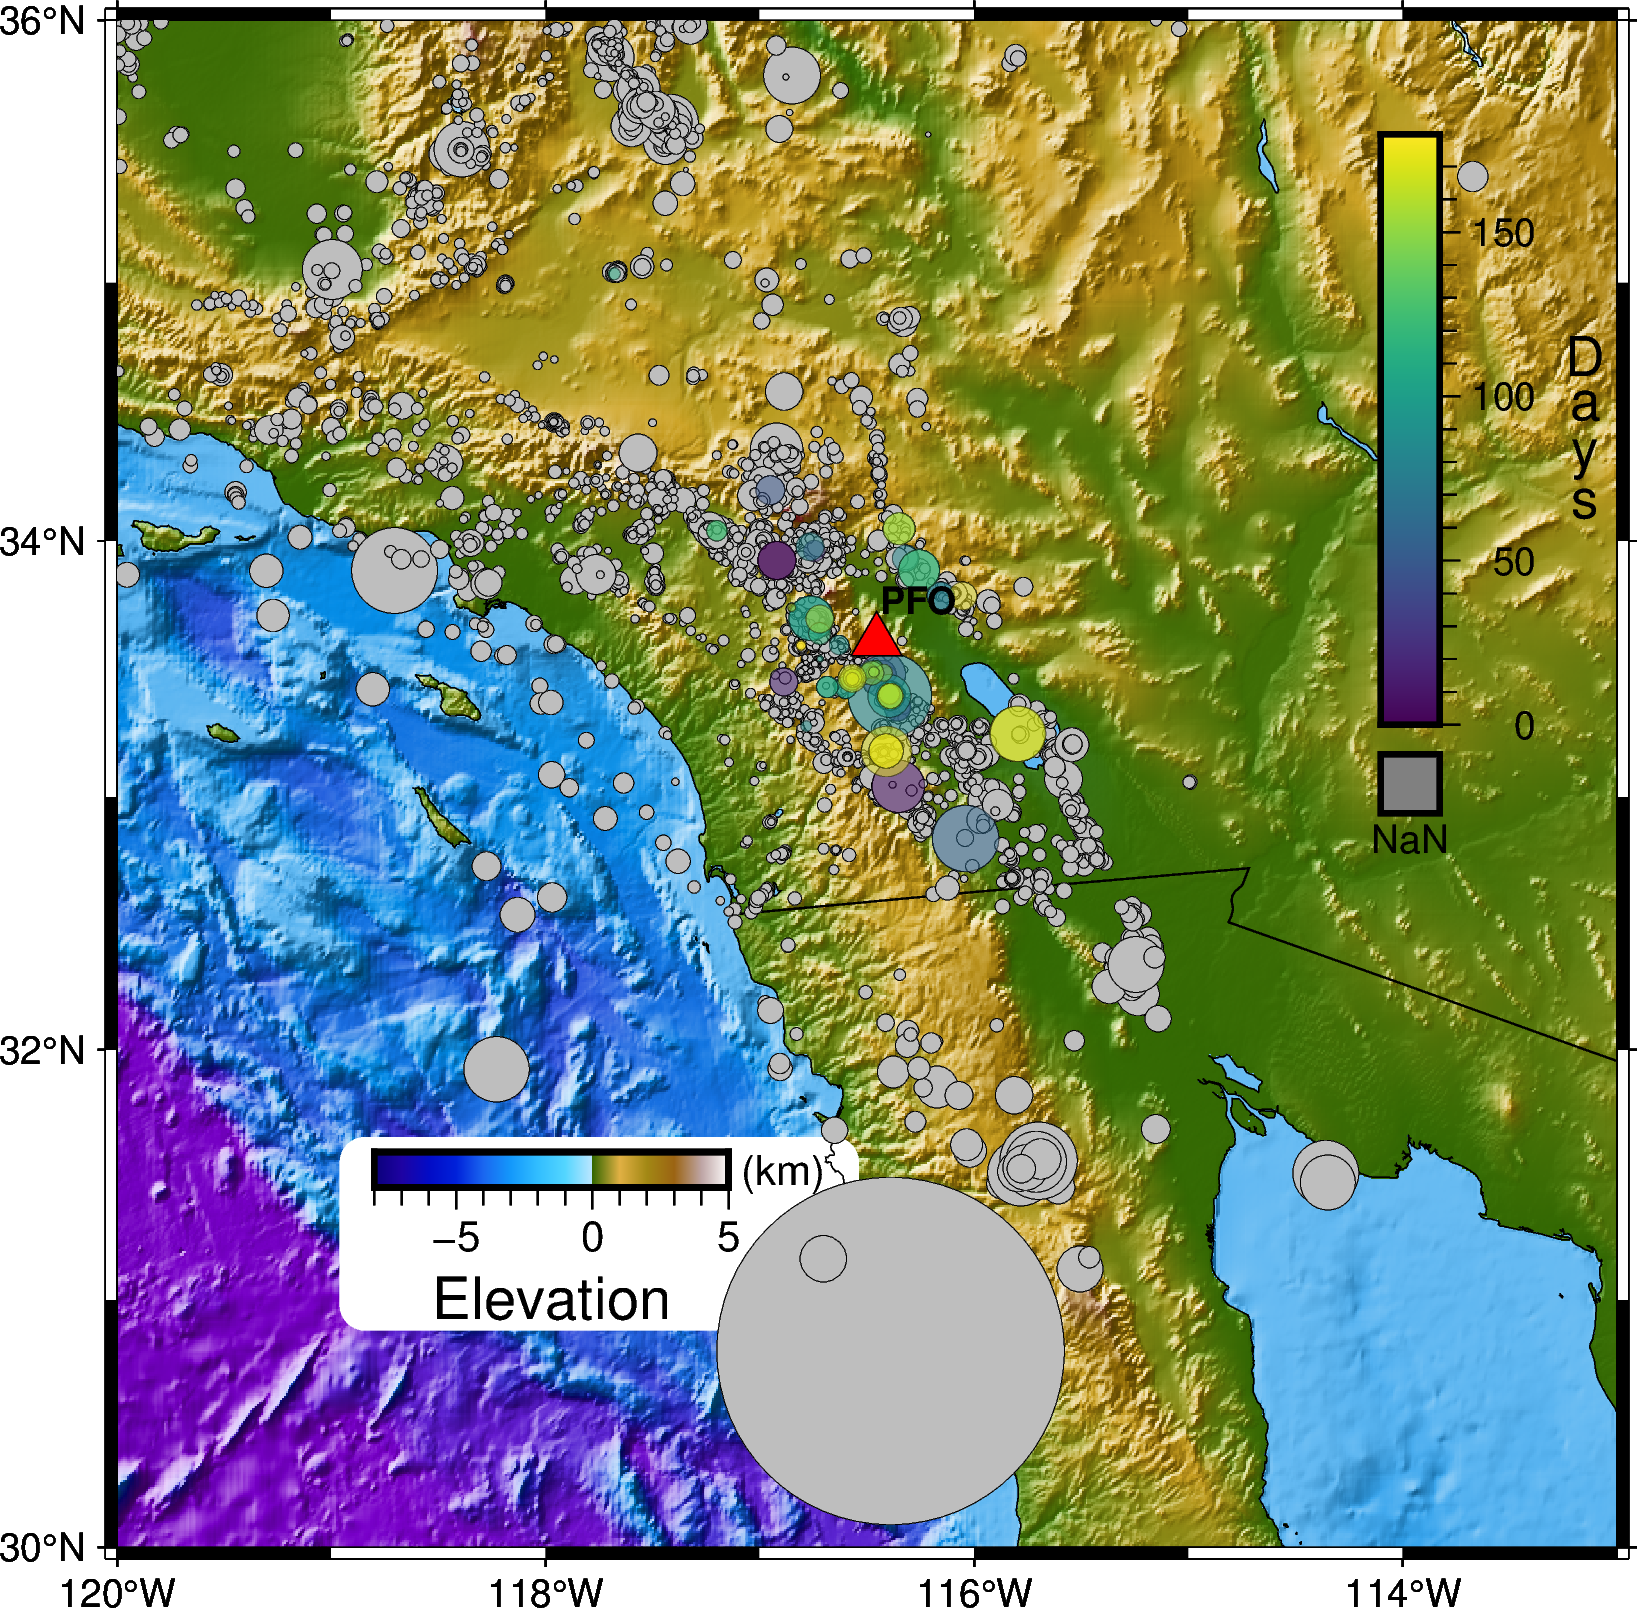

In [70]:
fig = __makeplot_eventmap(config, cat_select_df, events_all_df)

In [71]:
fig.savefig("map_triggered.png")

## Plot Histogram

In [72]:
def __makeplot_histogram(catalog_all_df, catalog_df):
    
    from sklearn.linear_model import LinearRegression
    from numpy import log10, array


    catalog_all_df.sort_values("magnitude")
    catalog_df.sort_values("magnitude")    
    
    ## bins=11, range=[-0.75,4.75]
    hh_cum, bins_cum, _ = plt.hist(catalog_all_df.magnitude, bins=15, rwidth=0.9, color='#3776ab', cumulative=True)    
    plt.close()    
    bins_cum = [bins_cum[jj] + (abs(bins_cum[jj+1]-bins_cum[jj])/2) for jj in range(len(bins_cum)-1)]

    hh, bins, _ = plt.hist(catalog_all_df.magnitude, bins=15, rwidth=0.9, color='#3776ab', log=True)    
    plt.close()
    bins = [bins[jj] + (abs(bins[jj+1]-bins[jj])/2) for jj in range(len(bins)-1)]
    
    x, y = array(bins)[4:], log10(hh[4:])
    
    ## ________________________________
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    
    ## plot histograms
    ax.bar(array(bins), 10**log10(hh), width=0.25, color='lightblue', zorder=2, alpha=0.8)
    ax.bar(x, 10**y, width=0.25, zorder=2)
    
        
    ## linear regression
    model = LinearRegression().fit(x.reshape((-1, 1)), y)

    r_sq = model.score(x.reshape((-1, 1)), y)

    x_axis = linspace(min(bins), max(bins), 50)
    
    reg = model.intercept_ + model.coef_ * x_axis
    
    print(model.intercept_,model.coef_[0])
    ax.plot(x_axis, 10**reg, color="k", ls="--", label=f"f(x)={round(model.coef_[0],1)}x+{round(model.intercept_,1)}")
    
    ## plot cumsum
    ax2 = ax.twinx()
    ax2.plot(bins_cum, hh_cum, color="darkred", ls="-.", zorder=-1)
    ax2.set_yscale("log")
    ax2.tick_params(axis="y", colors="darkred")
    ax2.set_zorder(-1)
    ax.patch.set_visible(False)
    
    ax.legend(loc="center right")
    
    ax.set_yscale("log")
    
    ax.set_xlabel("Magnitude", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax2.set_ylabel("Total Events", fontsize=14, color="darkred")
    
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax2.tick_params(axis='y', labelsize=11)
    
#     ax.set_title(f"triggered={len(catalog_df)}")

    plt.show();
    return fig

In [73]:
fig = __makeplot_histogram(events_all_df, cat_select_df)

fig.savefig("catalog_all_histo.png")

ModuleNotFoundError: No module named 'sklearn'